In [2]:
import os
import time

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as log_progress
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

## Параметры

In [3]:
C = [0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]
P = [2, 3, 4, 5]
Beta = [1, 2, 3, 4, 5]

## Кернелы

In [4]:
def linear(_):
    return np.dot

def polynomial(p):
    return lambda a, b: np.power(np.dot(a, b), p)

def gaussian(beta):
    return lambda a, b: np.exp(-beta * np.power(np.linalg.norm(a - b), 2))

kernels = [linear, polynomial, gaussian]

parameters = {
    linear: [0],
    polynomial: P,
    gaussian: Beta,
}

## Генерация матриц

In [5]:
def ds_to_kernel_matrix(ds, kernel):
    n = ds.shape[0]
    kernel_matrix = [[0 for i in range(n + 1)] for x in range(n)]
    vals = ds.values
    for idx in range(n):
        for jdx in range(n):
            kernel_matrix[idx][jdx] = kernel(vals[idx][:-1], vals[jdx][:-1])
        kernel_matrix[idx][n] = -1 if vals[idx][-1] == 'N' else 1
    return kernel_matrix

def ds_to_point_kernel_row(ds, point, kernel):
    n = ds.shape[0]
    vals = ds.values
    row = [0 for i in range(n)]
    for i in range(n):
        row[i] = kernel(vals[i][:-1], point[:-1])
    return row

## Запуск плюсового кода

In [6]:
def run_svm(mat, C):
    with open('kernel.txt', 'w') as f:
        f.write('{}\n'.format(len(mat)))
        for l in mat:
            f.write('{}\n'.format(' '.join(map(str, l))))
        f.write('{}\n'.format(C))
    os.system('./svm')
    alpha = []
    with open('result.txt', 'r') as f:
        for line in f:
            alpha.append(float(line))
    b = alpha.pop()
    return (alpha, b)

## Предсказания и подсчет точности

In [7]:
def predict(point_kernel_row, mat, alpha, b):
    res = 0.0
    for j in range(len(mat)):
        res += mat[j][-1] * alpha[j] * point_kernel_row[j]
    res = int(np.sign(res + b))
    return res
    

def count_accuracy_lov(ds, kernel, c):
    true = 0
    for idx in range(len(ds.values)):
        row = ds.values[idx]
        ds_dropped = ds.drop([idx])
        # start_t = time.time() * 1000
        mat = ds_to_kernel_matrix(ds_dropped, kernel)
        # mat_t = time.time() * 1000
        (alpha, b) = run_svm(mat, c)
        # svm_t = time.time() * 1000
        # print("Matrix time", mat_t - start_t)
        # print("SMO time", svm_t - mat_t)
        
        point = ds.values[idx]
        point_kernel_row = ds_to_point_kernel_row(ds_dropped, point, kernel)
        
        predicted = predict(point_kernel_row, mat, alpha, b)
        target = 1 if row[-1] == 'P' else -1
        true += 1 if (target * predicted > 0) else 0
    
    return true / ds.shape[0]

def count_accuracy(ds, kernel, c):
    true = 0
    mat = ds_to_kernel_matrix(ds, kernel)
    (alpha, b) = run_svm(mat, c)
    for idx in range(len(mat)):
        predicted = predic(idx, mat, alpha, b)
        target = mat[idx][-1]
        true += 1 if (target * predicted > 0) else 0
    return true / ds.shape[0]

## Рисовалка

In [8]:
def draw(ds, params, detalization):
    # counting some results
    (k, p, c) = params
    kernel = k(p)
    
    mat = ds_to_kernel_matrix(ds, kernel)
    (alpha, b) = run_svm(mat, c)
    
    # selecting grid size
    min_x, min_y, _ = ds.min()
    max_x, max_y, _ = ds.max()
    delta_x = (max_x - min_x) / detalization;
    delta_y = (max_y - min_y) / detalization;
    co = detalization / 5;
    
    points_x = np.linspace(min_x - delta_x * co, max_x + delta_x * co, int(detalization + 2 * co))
    points_y = np.linspace(min_y - delta_y * co, max_y + delta_y * co, int(detalization + 2 * co))
    grid = np.fromfunction(lambda i, j: i - i, (len(points_x), len(points_y)), dtype=int)
    # print(grid)
    for i in range(len(points_y)):
        y = points_y[i]
        for j in range(len(points_x)):
            x = points_x[j]
            grid[i][j] = predict(ds_to_point_kernel_row(ds, np.array([x, y, 0]), kernel), mat, alpha, b)
    # print(grid)
    
    
    plt.figure(figsize=(10, 10))
    plt.xlim(min_x - delta_x * co, max_x + delta_x * co)
    plt.ylim(min_y - delta_y * co, max_y + delta_y * co)
    plt.pcolormesh(points_x, points_y, grid, shading='auto', cmap=ListedColormap(['#87CEFA', '#FFAAAA']))
    
    xn, yn, _ = ds[ds['class'] == 'N'].T.values
    xp, yp, _ = ds[ds['class'] == 'P'].T.values
    
    plt.scatter(xn, yn, color='#0000CD', s=40)
    plt.scatter(xp, yp, color='#FF0000', s=40)
    
    plt.show()

# Chips

In [11]:
results = {}
params_sets = []
for k in kernels:
    for p in parameters[k]:
        for c in C:
            params_sets.append((k, p, c))

In [12]:
ds = pd.read_csv('chips.csv')
for params in log_progress(params_sets):
    (k, p, c) = params
    if params in results:
        # print(params, results[params])
        continue
    results[params] = count_accuracy_lov(ds, k(p), c)
    # print(params, results[params])

In [16]:
results_list = list(results.items())
results_sorted = sorted(results_list, key=lambda x: -x[1])
best = results_sorted[0]
best

((<function __main__.gaussian(beta)>, 2, 5.0), 0.8305084745762712)

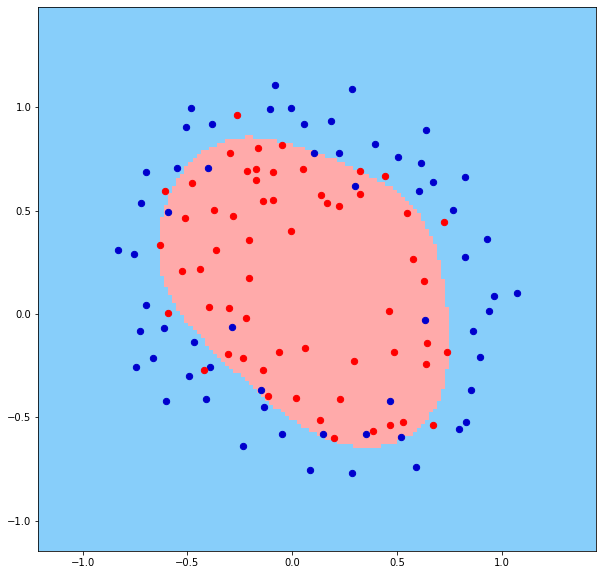

In [18]:
draw(ds, best[0], 100)

((<function polynomial at 0x7f7ad75e0940>, 2, 1.0), 0.7542372881355932)


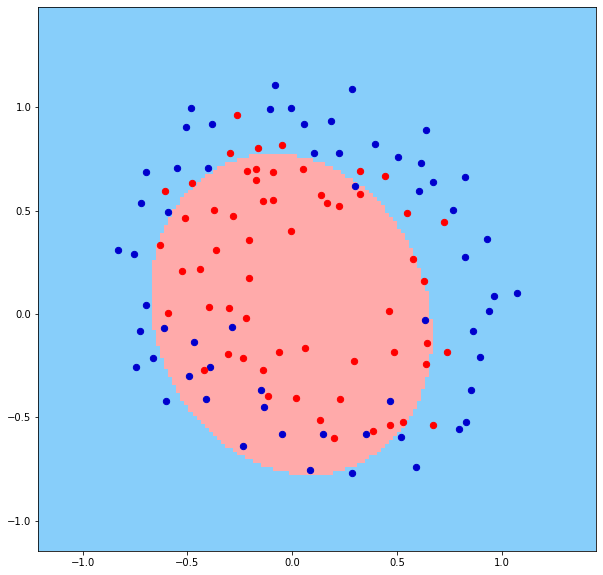

In [19]:
best_poly = list(filter(lambda x: x[0][0] == polynomial, results_sorted))[0]
print(best_poly)
draw(ds, best_poly[0], 100)

((<function linear at 0x7f7ad75e08b0>, 0, 5.0), 0.5169491525423728)


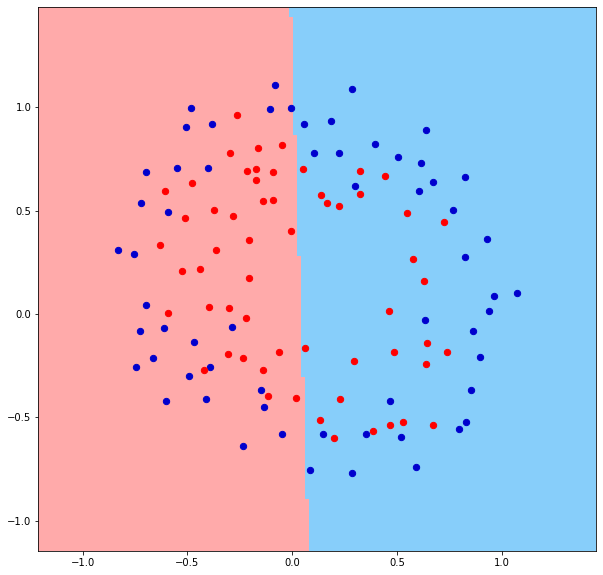

In [20]:
best_linear = list(filter(lambda x: x[0][0] == linear, results_sorted))[0]
print(best_linear)
draw(ds, best_linear[0], 100)

# Geysers

In [21]:
results2 = {}

In [22]:
ds2 = pd.read_csv('geyser.csv')
for params in log_progress(params_sets):
    (k, p, c) = params
    if params in results2:
        # print(params, results2[params])
        continue
    results2[params] = count_accuracy_lov(ds2, k
                                          (p), c)
    # print(params, results[params])

((<function gaussian at 0x7f7ad75e09d0>, 1, 0.05), 0.9009009009009009)


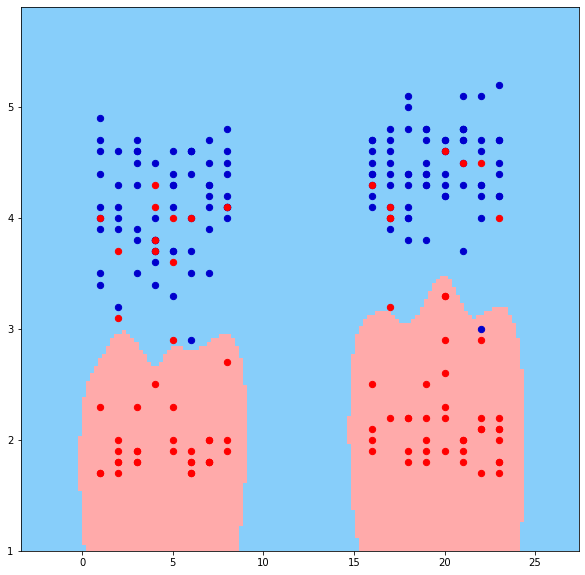

In [26]:
results2_list = list(results2.items())
results2_sorted = sorted(results2_list, key=lambda x: -x[1])
print(results2_sorted[0])
draw(ds2, results2_sorted[0][0], 100)

((<function linear at 0x7f7ad75e08b0>, 0, 0.05), 0.8963963963963963)


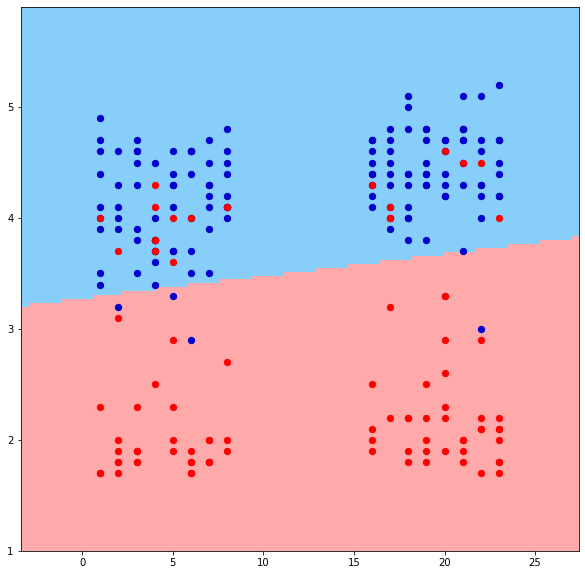

In [27]:
best_linear2 = list(filter(lambda x: x[0][0] == linear, results2_sorted))[0]
print(best_linear2)
draw(ds2, best_linear2[0], 100)

((<function polynomial at 0x7f7ad75e0940>, 2, 0.05), 0.8873873873873874)


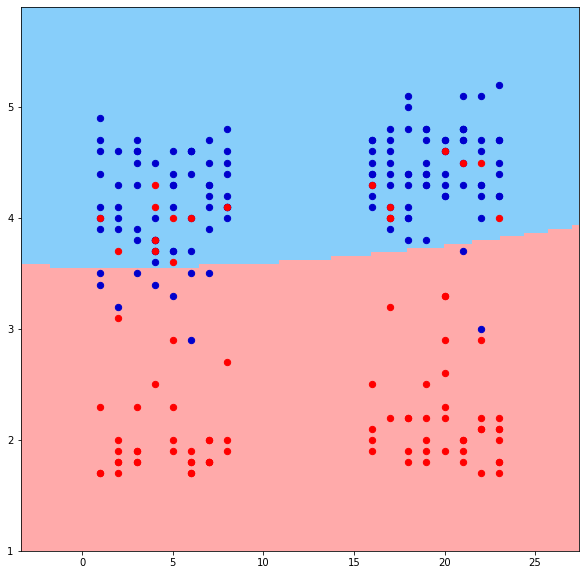

In [29]:
best_poly2 = list(filter(lambda x: x[0][0] == polynomial, results2_sorted))[0]
print(best_poly2)
draw(ds2, best_poly2[0], 100)